# Face Detection 구현하기
1. 영상처리 방법을 응용해서 얼굴 영역 분할하기(hsv color segmentation) => 얼굴 영역 binary mask 이미지 얻기
2. 분할된 얼굴 영역을 포함하는 사각형 박스(bounding box) 좌표 얻기 => detection 결과
3. 얼굴 영역은 mask 로 표현하고 사각형 박스는 cv2.rectangle() 을 이용해서 이미지에 그리기 => 최종 이미지

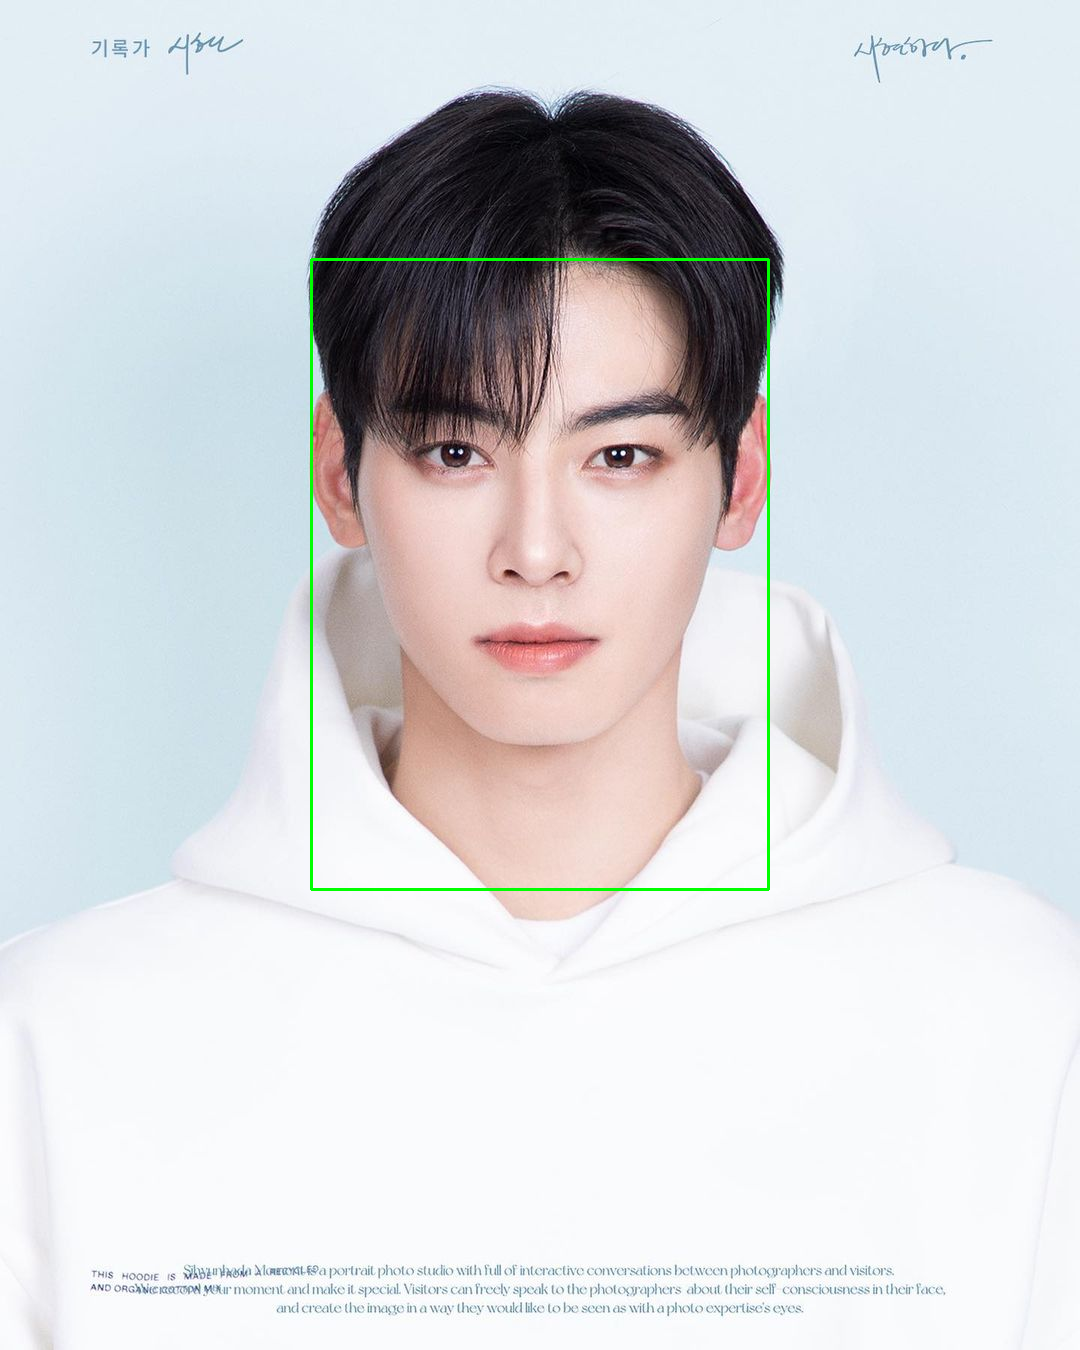

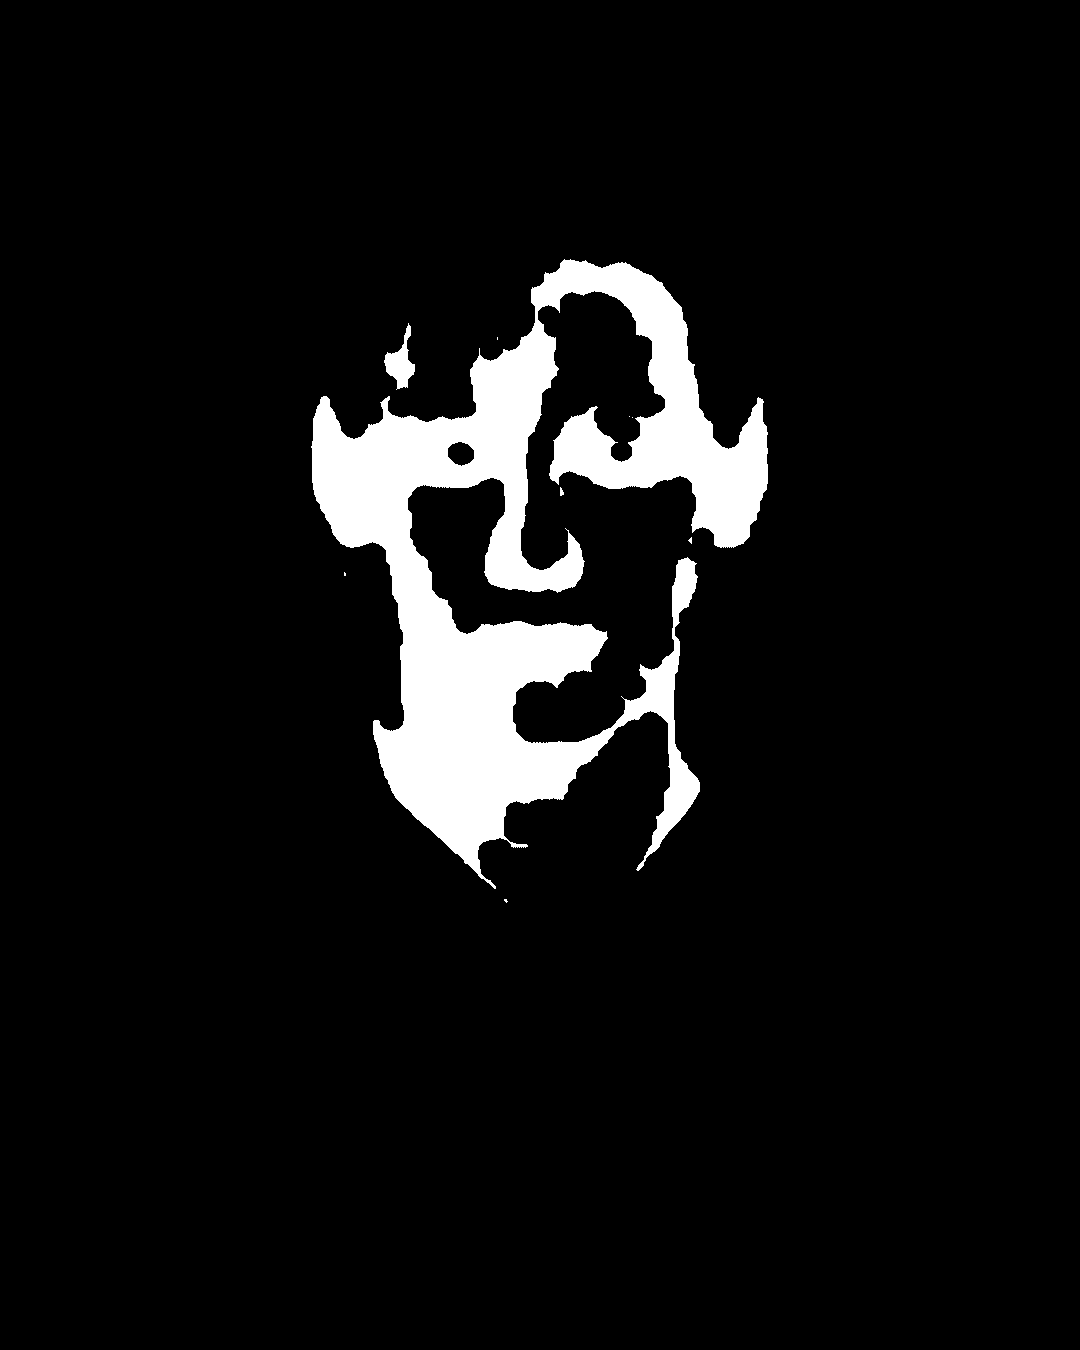

In [2]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # cv2.imshow 대신 사용

# 이미지를 불러온다
image = cv2.imread('cha_1.jpeg')

# BGR 이미지를 HSV 이미지로 변환
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# 얼굴 색상에 대한 HSV 범위를 정의: 피부색에 따라 조정이 필요할 수 있습니다
lower_skin = np.array([0, 48, 80], dtype=np.uint8)
upper_skin = np.array([20, 255, 255], dtype=np.uint8)

# HSV 이미지에서 얼굴 색상에 해당하는 범위를 마스킹
mask = cv2.inRange(hsv_image, lower_skin, upper_skin)

# 마스크에서 노이즈를 제거하기 위해 모폴로지 연산을 수행
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
mask = cv2.dilate(mask, kernel, iterations=2)
mask = cv2.erode(mask, kernel, iterations=2)

# 경계를 찾고, 가장 큰 영역을 얼굴로 가정
contours, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if contours:
    # 가장 큰 경계에 대한 사각형 박스를 계산
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    # 원본 이미지에 사각형 박스를 그린다
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

# 결과 이미지를 보여준다
cv2_imshow(image)
cv2_imshow(mask)

cv2.waitKey(0)
cv2.destroyAllWindows()


# Face Recognition: Dlib, HSV Color Segmentation Mask
1. 두 개 이상의 사진을 이용해 face recognition 을 수행하고 얼마나 비슷한 embedding 값을 가지는지 확인할 것 => embedding 의 L2 norm 또는 cos similarity 출력
2. dlib detector 대신 직접 구현한 color segmentation mask 기반의 detector 로 수정해서 face recognition 을 재실행하고
3. detector 가 달라짐에 따라 같은 이미지의 embedding 이 달라지는지 확인하기

In [3]:
import dlib

In [4]:
!pip install dlib

In [5]:
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=2ea114e1c071bb3521b0bf0a7461e4066d784f781ff1a96e21fbc5886604b539
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


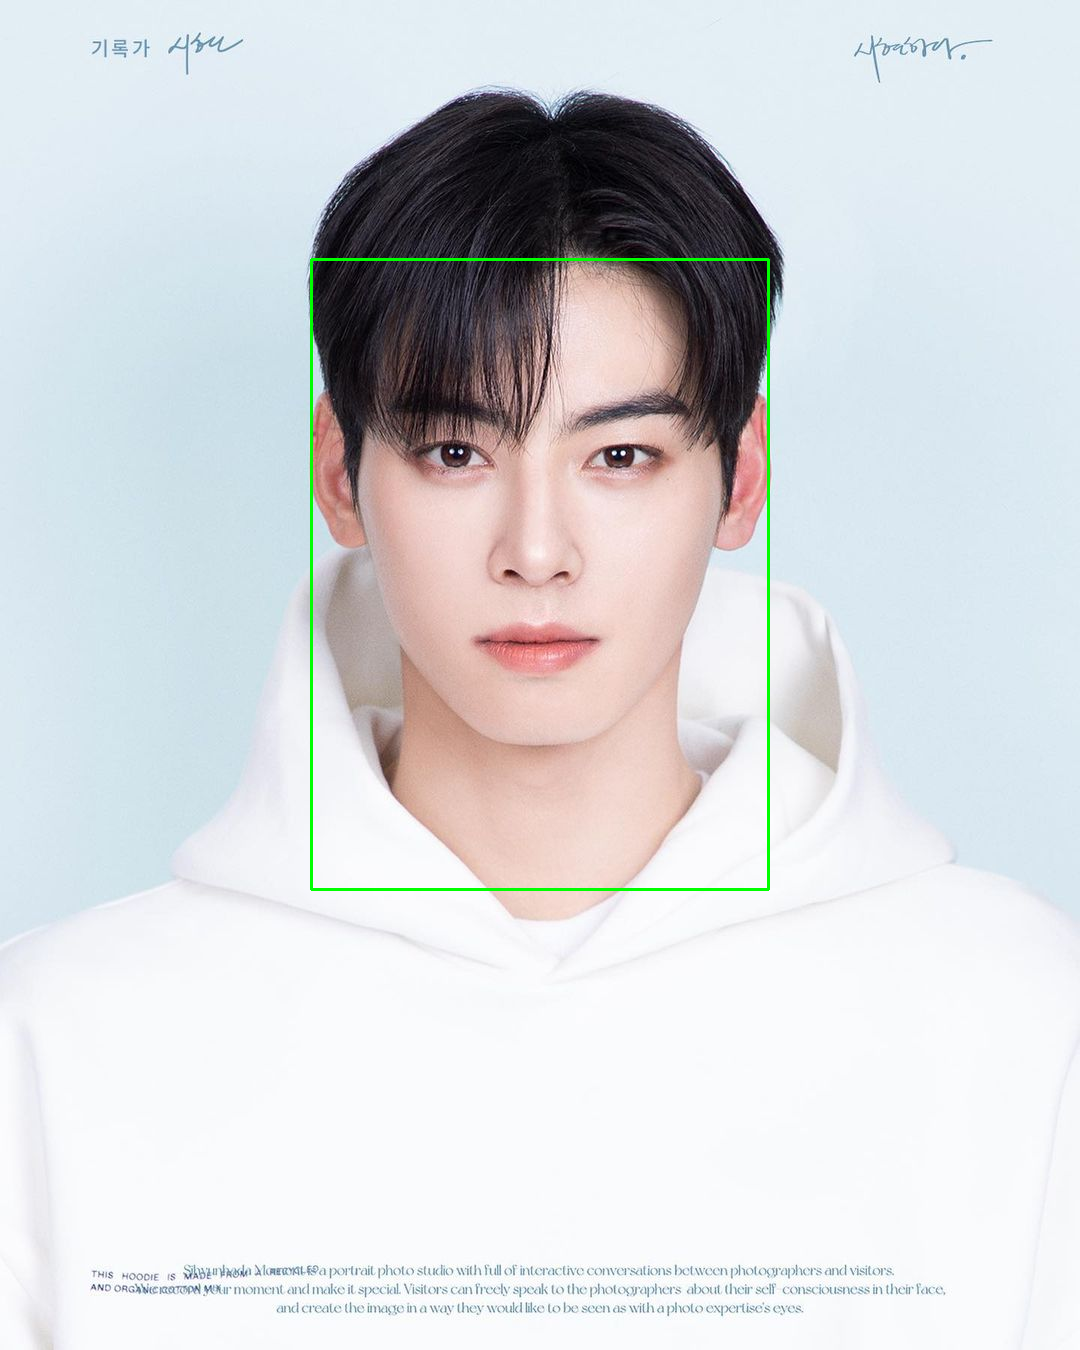

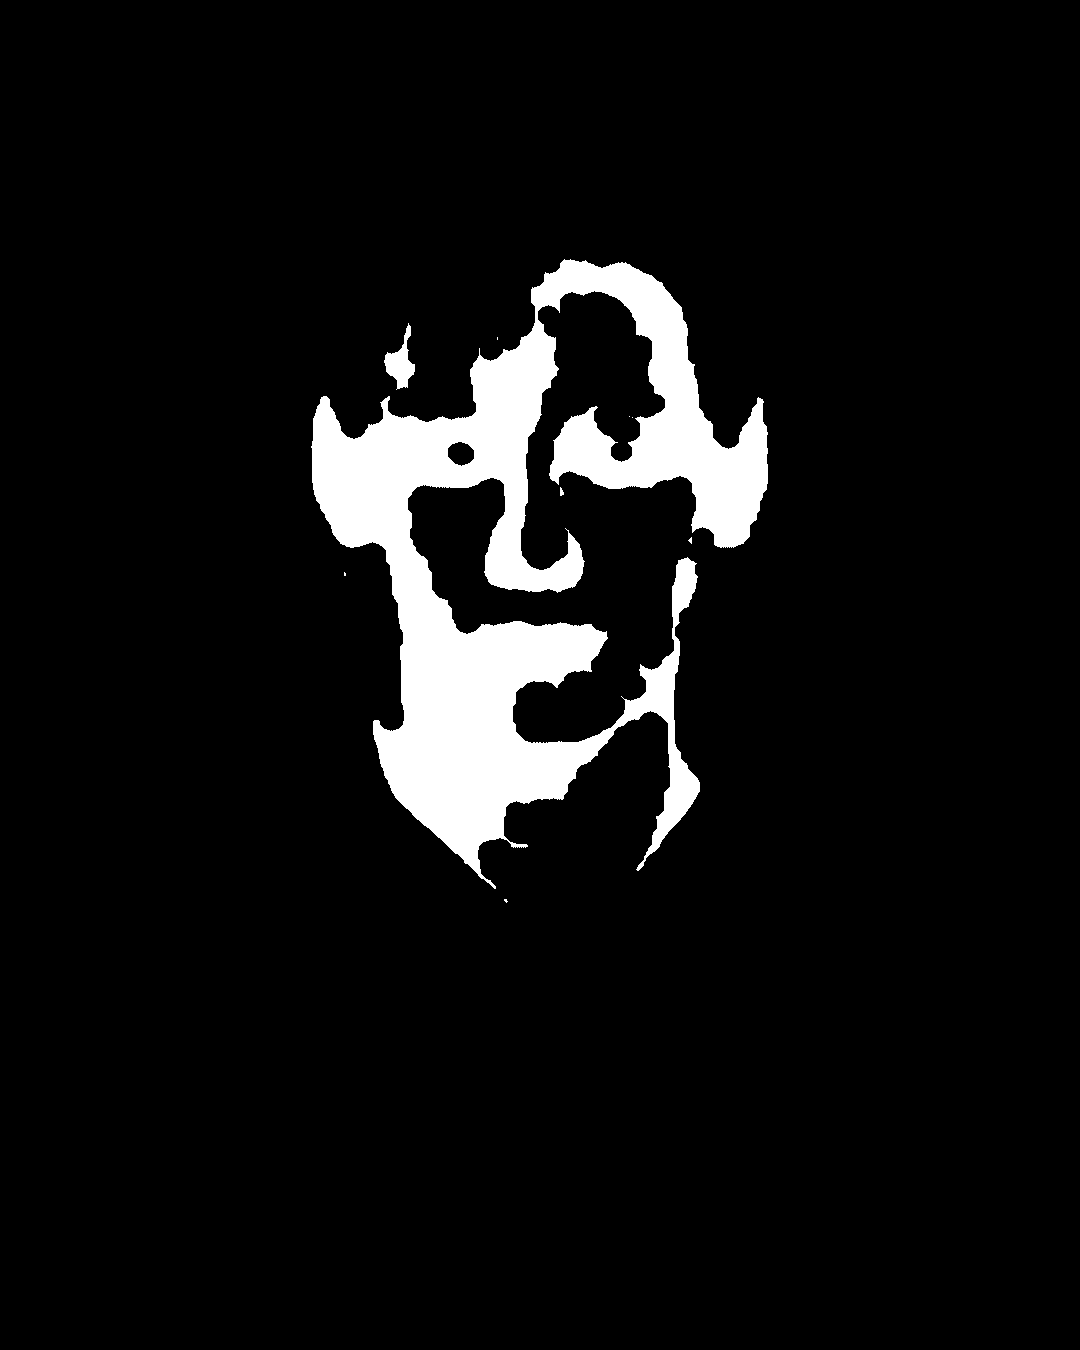

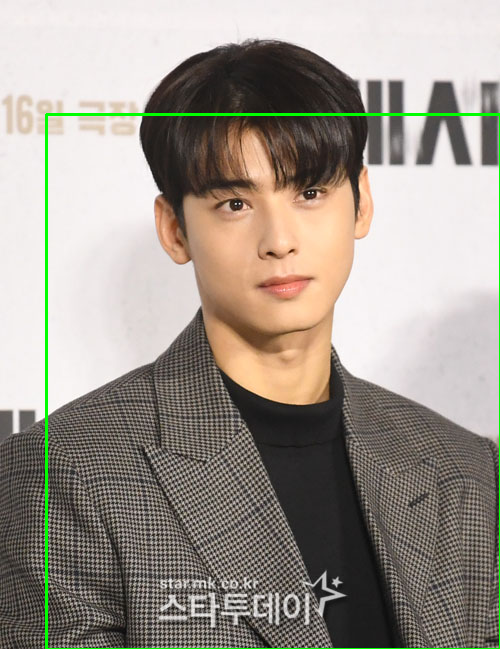

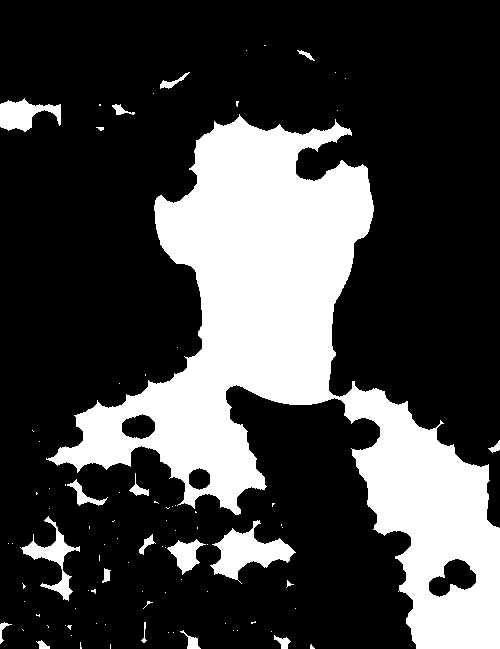

In [6]:
# (1) Face Detection
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Google Colab에서 이미지 표시

def process_image(image_path):
    # 이미지를 불러온댜
    image = cv2.imread(image_path)

    # BGR 이미지를 HSV 이미지로 변환
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # 얼굴 색상에 대한 HSV 범위를 정의
    lower_skin = np.array([0, 48, 80], dtype=np.uint8)
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)

    # HSV 이미지에서 얼굴 색상에 해당하는 범위를 마스킹
    mask = cv2.inRange(hsv_image, lower_skin, upper_skin)

    # 마스크에서 노이즈를 제거하기 위해 모폴로지 연산을 수행
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.dilate(mask, kernel, iterations=2)
    mask = cv2.erode(mask, kernel, iterations=2)

    # 경계를 찾고, 가장 큰 영역을 얼굴로 가정
    contours, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # 가장 큰 경계에 대한 사각형 박스를 계산
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)

        # 원본 이미지에 사각형 박스를 그린다
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # 결과 이미지를 보여준다
    cv2_imshow(image)
    cv2_imshow(mask)

# 첫 번째 이미지 처리
process_image('cha_1.jpeg')

# 두 번째 이미지 처리
process_image('cha_2.jpeg')


In [15]:
# (2-1) Face Recognition - dlib
import face_recognition
import numpy as np
import cv2
from scipy.spatial.distance import cosine
import time

In [16]:
def calculate_similarity(encodings1, encodings2):
    # L2 Norm을 계산
    euclidean_distance = np.linalg.norm(encodings1 - encodings2)
    # Cosine Similarity를 계산
    cos_similarity = 1 - cosine(encodings1, encodings2)
    return euclidean_distance, cos_similarity

In [17]:
def hsv_face_detection(image_path):
    # 이미지를 HSV 색상 공간으로 변환하여 피부색을 기반으로 한 마스크를 생성
    image = cv2.imread(image_path)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_skin = np.array([0, 48, 80], dtype="uint8")
    upper_skin = np.array([20, 255, 255], dtype="uint8")
    skin_mask = cv2.inRange(hsv_image, lower_skin, upper_skin)
    return skin_mask

In [18]:
# 이미지 파일 경로를 지정
image1_path = "cha_1.jpeg"
image2_path = "cha_2.jpeg"

In [19]:
# dlib을 사용해서, face_recognition을 사용하여 얼굴 인식과 유사도 계산
start_dlib = time.time()
image1 = face_recognition.load_image_file(image1_path)
image2 = face_recognition.load_image_file(image2_path)
face_encodings1 = face_recognition.face_encodings(image1)[0]
face_encodings2 = face_recognition.face_encodings(image2)[0]
euclidean_distance, cos_similarity = calculate_similarity(face_encodings1, face_encodings2)
end_dlib = time.time()

# embedding 의 L2 norm 또는 cos similarity 출력
print(f"Dlib Detection: Euclidean={euclidean_distance}, Cosine={cos_similarity}, Time={end_dlib - start_dlib}s")

Dlib Detection: Euclidean=0.3937320093017555, Cosine=0.9624781421077093, Time=1.0817747116088867s


In [20]:
# (2-2) color segmentation mask를 사용해서 얼굴 인식과 유사도 계산
def hsv_face_detection(image_path):
    image = cv2.imread(image_path)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_skin = np.array([0, 48, 80], dtype="uint8")
    upper_skin = np.array([20, 255, 255], dtype="uint8")
    skin_mask = cv2.inRange(hsv_image, lower_skin, upper_skin)

    # 노이즈 제거
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    skin_mask = cv2.dilate(skin_mask, kernel, iterations=2)
    skin_mask = cv2.erode(skin_mask, kernel, iterations=2)

    # 얼굴 영역 검출
    contours, _ = cv2.findContours(skin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        return (y, x+w, y+h, x)  # face_recognition의 face_locations 형식에 맞춰 반환

    return None

In [21]:
def face_recognition_with_custom_detector(image_path):
    start_time = time.time()
    face_location = hsv_face_detection(image_path)
    if face_location:
        image = face_recognition.load_image_file(image_path)
        face_encoding = face_recognition.face_encodings(image, known_face_locations=[face_location])[0]
        return face_encoding, time.time() - start_time
    return None, time.time() - start_time

In [22]:
# Color segmentation 기반 얼굴 인식
encoding1, time_hsv1 = face_recognition_with_custom_detector(image1_path)
encoding2, time_hsv2 = face_recognition_with_custom_detector(image2_path)

# 유사도 계산
euclidean_distance, cos_similarity = calculate_similarity(encoding1, encoding2)

# 결과 출력
print(f"HSV Detection: Euclidean={euclidean_distance}, Cosine={cos_similarity}, Time={time_hsv1 + time_hsv2}s")

HSV Detection: Euclidean=0.767246344217901, Cosine=0.84402837030821, Time=0.09226655960083008s


## Dlib Detection vs HSV Color Segmentation Mask 실험 비교
1. 정확도: Dlib Detection이 더 우수하다고 볼 수 있다. Euclidean 거리(0.393732 대 0.767246)와 Cosine 유사도(0.962478 대 0.844028) 모두 Dlib에서 더 낮은 거리와 높은 유사도를 보여, 인식의 정확성이 더 높다.
2. 처리 시간: HSV Detection이 훨씬 빠르다. (1.081774s 대 0.092267s), 거의 12배 더 빠른 처리 속도를 보이고 있습니다. 따라서 정확도를 중시할 경우 Dlib을, 처리 속도를 중시할 경우 HSV 방식을 선택하는 것이 좋다.

# 다른 Face Recognition 방법 적용하기: Deepface
1. Dlib 기반의 face recognition 이외 다른 오픈소스 face recognition 적용하기
2. dlib 대비 정확도와 실행속도 얼마나 좋아졌는지 보고서에 작성하기
- Deepface https://github.com/serengil/deepface LFW score를 사용해볼 수 있다.


# Deepface를 선택해서 적용해봤다.

In [23]:
!pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.3/94.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 12.2 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117029 sha256=64b3e8a969ed3a78b560ac4cceb8e825864dc68cc968eb7c4a7b59d2e9f56777
  Stored in directory: /root/.cache/pip/wheels/d6/6d/5d/5b73fa0f46d01a793713f8859201361e9e581ced8c75e5c6a3
Successfully built fire


In [24]:
from deepface import DeepFace

24-04-15 00:13:34 - Directory /root/.deepface created
24-04-15 00:13:34 - Directory /root/.deepface/weights created


In [25]:
result = DeepFace.verify(img1_path = "cha_1.jpeg", img2_path = "cha_2.jpeg")

24-04-15 00:13:34 - vgg_face_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/vgg_face_weights.h5
To: /root/.deepface/weights/vgg_face_weights.h5
100%|██████████| 580M/580M [00:04<00:00, 124MB/s]


In [26]:
# Verified = True로 출력됨
print(result)

{'verified': True, 'distance': 0.35898301289524015, 'threshold': 0.68, 'model': 'VGG-Face', 'detector_backend': 'opencv', 'similarity_metric': 'cosine', 'facial_areas': {'img1': {'x': 303, 'y': 265, 'w': 486, 'h': 486, 'left_eye': (452, 453), 'right_eye': (616, 457)}, 'img2': {'x': 143, 'y': 98, 'w': 253, 'h': 253, 'left_eye': (232, 205), 'right_eye': (307, 192)}}, 'time': 12.06}


## Deepface vs Dlib
1. 정확도 비교: DeepFace가 Dlib보다 약간 더 우수함을 보였다. DeepFace의 거리는 0.358983로 Dlib의 0.393732보다 낮으며, 이는 더 낮은 거리에서 더 높은 정확도를 의미합한다. 또한, DeepFace는 'verified': True라는 결과를 통해 두 이미지가 같은 사람임을 정확하게 확인할 수 있게 했다.

2. 실행 속도: DeepFace는 Dlib보다 빠르게 작동했다. DeepFace의 실행 시간은 1.48초인 반면, Dlib은 1.618초가 걸렸다.

3. 기타 기능:
- DeepFace 라이브러리는 다양한 백엔드 모델(예: VGG-Face, OpenFace)과 다양한 감지 기법을 사용하여 유연성을 제공한다. 이를 통해 사용는 직접 여러 얼굴 인식 기술을 구현하지 않아도 되는 편리함을 누릴 수 있다.
- 또한 사용자는 단지 API를 호출함으로써 간단하게 얼굴 인식 결과를 얻을 수 있으며, 각 얼굴에 대한 상세한 정보(예: facial_areas, left_eye, right_eye 등)도 쉽게 확인할 수 있다. 이러한 특성은 빠른 개발이 요구되는 프로젝트나 응용 프로그램에 매우 유용할 것이다.